## Final rescale for paper 1 - Figures for talks

Final figures for the scaling section of paper 1 and cleaner fits for:

* Maximum and minimum squeezing of isopyncals (max $N^2/N^2_0$, min $N^2/N^2_0$ )
* Effective stratification ($N_{eff}$)
* Upwelling flux induced by the canyon ($\Phi$)

* Maximum and minimum squeezing of isopyncals iso-concentration lines (max $\partial_zC/\partial_zC_0$, min $\partial_zC/\partial_zC_0$ ) *These won't be necessary for the paper(?)* 
* Mean concentration just above the rim during the advective phase ($\bar{C}$)
* Tracer upwelling flux induced by the canyon ($\Phi_{Tr}$)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('talk')
sns.set_style('white')

In [4]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']
RC = CanyonGridOut.variables['RC']

In [5]:
# Constants and scales

g = 9.81 # accel. gravity
Hs = 149.8 # Shelf break depth
s = 0.0061 # shelf slope 

def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [6]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
records = canyon_records.main()

import nocanyon_records 
recordsNoC = nocanyon_records.main()

### Not all runs are used to fit all variables

**records_dyn** has all runs where f, N or U vary. USe this list to fit upwelling flux $\Phi$ and modify *Howatt and Allen 2013*.

**records_epsilon** has all runs in records_dyn plus the runs with a heaviside Kv profile. Use this list to fit $\Phi$ with scaled N.

**records_real** has all runs in records_epsilon plus the runs with a Kv profile inspired in observations.

In [7]:
# Indices of all runs that will be considered for paper 1

select_rec = [0,1,2,3,4,5,51,6,7,8,9,10,17,18,19,20,21,
              22,23,24,25,26,27,29,30,31,32,33,
              34,35,38,39,41,42,43,44,45,46,47,48,49]#,52, 53, 54, 55, 56, 57, 58, 59, 60]

for ii in select_rec:
    print(ii,records[ii].label2, records[ii].name)

0 base case CNTDIFF_run38
1 $\uparrow$ $K_{bg}$ CNTDIFF_run37
2 $\uparrow \uparrow$ $K_{bg}$ CNTDIFF_run36
3 $\uparrow$ $N_0$ CNTDIFF_run45
4 $\uparrow \uparrow$ $N_0$ CNTDIFF_run73
5 $\Downarrow$ $N_0$ CNTDIFF_run75
51 $\downarrow \downarrow N_0$ CNTDIFF_run81
6 $\downarrow$ $N_0$ CNTDIFF_run79
7 $\uparrow f$ CNTDIFF_run67
8 $\downarrow \downarrow$ $f$ CNTDIFF_run51
9 $\downarrow f$ CNTDIFF_run69
10 $\Downarrow f$ CNTDIFF_run71
17 $\downarrow$ U LOWER_BF_run01
18 $\downarrow \downarrow$ U LOW_BF_run01
19 $\Downarrow$ U LOWEST_BF_run01
20 $\Downarrow$ U, $\downarrow \downarrow$ $N_0$ LOWEST_BF_run03
21 $\Downarrow$ U, $\uparrow \uparrow$ $N_0$ LOWEST_BF_run05
22 $\Downarrow$ U, $\Downarrow$ $f$ LOWEST_BF_run07
23 $\Downarrow$ U, $\uparrow \uparrow K_{can}$ LOWEST_BF_run11
24 $K_{can}$ Monterey (bot) 3DVISC_REALISTIC_run01
25 $K_{can}$ Eel (bot) 3DVISC_REALISTIC_run02
26 $K_{can}$ Monterey 3DVISC_REALISTIC_run03
27 $K_{can}$ Ascension (bot) 3DVISC_REALISTIC_run05
29 $\Uparrow \Uparrow K

In [8]:
# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22] 
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,39,41,42,43,44,45,46,47,48,49]#,52, 53, 54, 55, 56, 57, 58, 59, 60]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_real has all the runs in records_epsilon plus the realistic runs
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,41,42,39,43,44,45,46,47,48,49,24,25,26,27]#,52,53, 54, 55, 56, 57, 58, 59, 60]
records_real = []
for ii in ind:
    records_real.append(records[ii])

In [9]:
records_sel = []

for ind in select_rec:
    records_sel.append(records[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' 
            %(records[ind].exp_code,records[ind].exp_code,records[ind].run_num))
    dfcan = pd.read_csv(file)
    records[ind].HCW = dfcan['HCW']
    records[ind].HCWTr1 = dfcan['HCWTr1']
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    records[ind].TrMassTot = dfcan['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']

In [10]:
t=6.5
stname = 'UwH' #Station downstream head of canyon

keys2 = ['N_tt12','N_tt14']

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = np.empty(len(keys2))
    Nbe = np.empty(len(keys2))
    
    if records[ind].L > 13000:
        print(records[ind].L)
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.max(df[keys2[ii]][:]) 
            Nbe[ii] = np.min(df[keys2[ii]][12:16]) 
    
    elif (records[ind].L < 13000) & (records[ind].L > 8500):
        print(records[ind].L)
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.max(df[keys2[ii]][:]) 
            Nbe[ii] = np.min(df[keys2[ii]][16:19]) 
    
        
    else:
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.max(df[keys2[ii]][:]) 
            Nbe[ii] = np.min(df[keys2[ii]][20:23]) 
        
        
    records[ind].Nab = np.mean(Nab)
    records[ind].Nbe = np.mean(Nbe)
    records[ind].Nab_std = np.std(Nab)
    records[ind].Nbe_std = np.std(Nbe)

In [11]:
keys2 = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16','dTrdz_tt18']

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    dTrab = 0
    dTrbe = 0
    
    if records[ind].L > 13000:
        for key,ii in zip(keys2, range(len(keys2))):
            dTrab = dTrab + np.min(df[keys2[ii]][:]) 
            dTrbe = dTrbe + np.max(df[keys2[ii]][12:16]) 
        records[ind].dTr0 = df['dTrdz_tt00'][10] 
    
    elif (records[ind].L < 13000) & (records[ind].L > 8500):
        for key,ii in zip(keys2, range(len(keys2))):
            dTrab = dTrab + np.min(df[keys2[ii]][:]) 
            dTrbe = dTrbe + np.max(df[keys2[ii]][16:19]) 
        records[ind].dTr0 = df['dTrdz_tt00'][10] 
   
    else:
        for key,ii in zip(keys2, range(len(keys2))):
            dTrab = dTrab + np.min(df[keys2[ii]][:]) #0:20
            dTrbe = dTrbe + np.max(df[keys2[ii]][20:23]) #20:24
        records[ind].dTr0 = df['dTrdz_tt00'][10]
    records[ind].dTr_ab = dTrab/  len(keys2)
    records[ind].dTr_be = dTrbe/  len(keys2)
    

In [12]:
keys2 = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16','Tr_profile_tt18']

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = np.zeros(len(keys2))
    
    if records[ind].L > 13000:
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.nanmean(df[keys2[ii]][11:13]) # just above rim depth
        records[ind].Tr0 = (df['Tr_profile_tt00'][13])
    elif (records[ind].L < 13000) & (records[ind].L > 8500):
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.nanmean(df[keys2[ii]][15:17]) # just above rim depth
        records[ind].Tr0 = (df['Tr_profile_tt00'][17])
    else:
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.nanmean(df[keys2[ii]][19:21]) # just above rim depth
        records[ind].Tr0 = (df['Tr_profile_tt00'][21])
    
    records[ind].Tr = np.nanmean(Nab)
    records[ind].Tr_std = np.std(Nab)
    

## Stratification and upwelling flux

In previous notebooks I found that the upwelling flux is porportional to an effective stratification $N_{eff}$ given by the weighted sum of the maximum stratification above the rim, near the head and the minimum stratification below the rim:

$$N_{eff} = {0.75N_{max}+0.25N_{min}}$$

So first, we scale $N_{max}$ and $N_{min}$ using the information we got from the 1D model and modifications to the 1D model due to the enhanced diffusion above the rim when $\epsilon$ is larger than the step case.

Once we get both N's, we can scale $N_{eff}$ and use it in the depth scale $D_h$ in the scaling for $\Phi$ by Howatt and Allen as $D_{eff}=fL/N_{eff}$, with proper fitting parameters.

In [15]:
# Get kv form initial files

records_kv_files = [24,25,26,27,29,30,31,32,33,34,38,39,41,42,43,44,45,46,47,48,49]

kv_dir = '/ocean/kramosmu/Building_canyon/BuildCanyon/Stratification/616x360x90/'
ini_kv_files = [kv_dir + 'KrDiff_Mty_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_Eel_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_Mty_rim_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_Asc_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e10_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e25_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e50_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e100_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e15_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e75_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv1E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e25_kv1E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e100_kv1E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e25_kv5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e100_kv5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv8E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_exact1p2E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv2p5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv5E4_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_exact_nosmooth_90zlev_616x360_Quad.bin',
                ]

dt = np.dtype('>f8')  # float 64 big endian
st = [240, 200] # y, x indices of UwH station
Hrim = 135
dd = 1
ini_kv_profiles = np.zeros((len(ini_kv_files),nz))

for file, ii in zip(ini_kv_files, records_kv_files):
    data = np.fromfile(file, dt)
    ini_kv = np.reshape(data,(90,360,616),order='C')
    
    KK = ini_kv[:, st[0], st[1]] 
    
    records[ii].Zdif = (((KK[int(Hrim/5)+1]-KK[int(Hrim/5)-1]))*t*3600*24)**0.5
    records[ii].dk =  KK[int(Hrim/5)+1]-KK[int(Hrim/5)-1]
    records[ii].Kz =  KK[int(Hrim/5)-4]
    records[ii].Kz_be =  KK[int(Hrim/5)+4]

In [16]:
for rec in records_real:

    Dz = abs(RC[int(Hrim/5)+1]-RC[int(Hrim/5)-1])
    rec.Z = ((rec.f*rec.u_mod*F(Ro(rec.u_mod,rec.f,rec.R))*rec.L)**(0.5))/rec.N
    
    if rec.kv == rec.kbg:
        rec.Zdif = 0
        rec.Sdif_min = np.exp(-0.15*rec.Zdif/Dz) # -0.1 comes from the 1D model
        rec.dk = 0
        rec.Kz = 1E-5
        rec.Kz_be = 1E-5
        rec.Sdif_max = (rec.Zdif/Dz)*np.exp(-(rec.Kz*t*3600*24)/((rec.epsilon)**2))
    
    else:
        rec.Sdif_min = np.exp(-0.15*rec.Zdif/Dz)
        rec.Sdif_max = (rec.Zdif/Dz)*np.exp(-(rec.Kz*t*3600*24)/((rec.epsilon)**2))
        
    rec.S_max = (rec.Z/rec.Hh)*np.exp(-rec.Kz*t*3600*24/rec.Z**2)
    rec.S_min = (rec.Z/rec.Hh)*np.exp(-rec.Kz_be*t*3600*24/rec.Z**2)

In [17]:
print(rec.name)

3DVISC_REALISTIC_run05


In [18]:
X1_be = np.array([rec.S_min for rec in records_epsilon])
X2_be = np.array([rec.Sdif_min for rec in records_epsilon])
Y_be = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_epsilon])

X1_ab = np.array([rec.S_max for rec in records_epsilon])
X2_ab = np.array([rec.Sdif_max for rec in records_epsilon])
Y_ab = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])

In [19]:
from sklearn import linear_model
reg_be = linear_model.LinearRegression()
reg_be.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(r'min $N^2/N^2_0$ = %1.2f $S^-$ + %1.2f $(1-S^-_{diff})$  %1.2f ' %
      (reg_be.coef_[0],reg_be.coef_[1],reg_be.intercept_))

reg_ab = linear_model.LinearRegression()
reg_ab.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(r'max $N^2/N^2_0$ = %1.2f $S^+$ + %1.2f $S^+_{diff}$ + %1.2f ' %
      (reg_ab.coef_[0],reg_ab.coef_[1],reg_ab.intercept_))

min $N^2/N^2_0$ = 2.72 $S^-$ + 2.19 $(1-S^-_{diff})$  -1.13 
max $N^2/N^2_0$ = 7.35 $S^+$ + 0.21 $S^+_{diff}$ + 0.82 


In [20]:
# Save values of N_eff and Phi

for rec in records_sel:  
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) 
                            for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) 
                               for ii in range (8,18)]))
    rec.Phi = Phi
    rec.Phi_std = Phi_std

for rec in records_real:
    rec.Nbe_scaled =  np.sqrt(reg_be.coef_[0]*rec.S_min +
                              reg_be.coef_[1]*rec.Sdif_min +
                              reg_be.intercept_)*rec.N
    rec.Nab_scaled =  np.sqrt(reg_ab.coef_[0]*rec.S_max +
                              reg_ab.coef_[1]*rec.Sdif_max +
                              reg_ab.intercept_)*rec.N
     
    if  (reg_be.coef_[0]*rec.S_min+ reg_be.coef_[1]*rec.Sdif_min +
         reg_be.intercept_)< 0 :
        rec.N_eff_scaled = (0.75*rec.Nab_scaled)
    else:
        rec.N_eff_scaled =  (0.75*rec.Nab_scaled + 0.25*rec.Nbe_scaled) 
    
    rec.Neff = (0.75*rec.Nab+0.25*rec.Nbe)

In [21]:
# find best slope parameter to use

for param in np.linspace(0.4, 1.3, 80):
    for rec in records_real:
        Se = SE(s, rec.N, rec.f, F(Ro(rec.u_mod,rec.f,rec.Wiso)), Ro(rec.u_mod,rec.f,rec.L))
        rec.X = ((F(Ro(rec.u_mod,rec.f,rec.Wiso)))**(1.5))*((Ro(rec.u_mod,rec.f,rec.L))**(0.5))*((1-param*Se)**3)

        rec.Phi_nonDim = rec.Phi/(rec.u_mod*rec.W*Dh(rec.f,rec.L,rec.N_eff_scaled))
        
    Y_array = np.array([rec.Phi_nonDim for rec in records_epsilon])
    X_array = np.array([rec.X for rec in records_epsilon])

    slope2, intercept2, r_value2, p_value2, std_err2 = scipy.stats.linregress(X_array,Y_array)

    print('Using parameter %1.2f: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(param, slope2, intercept2, r_value2))

Using parameter 0.40: slope = 1.53, intercept = 0.004, r-value = 0.718
Using parameter 0.41: slope = 1.59, intercept = 0.003, r-value = 0.729
Using parameter 0.42: slope = 1.66, intercept = 0.002, r-value = 0.740
Using parameter 0.43: slope = 1.73, intercept = 0.000, r-value = 0.751
Using parameter 0.45: slope = 1.80, intercept = -0.001, r-value = 0.762
Using parameter 0.46: slope = 1.87, intercept = -0.002, r-value = 0.772
Using parameter 0.47: slope = 1.95, intercept = -0.003, r-value = 0.783
Using parameter 0.48: slope = 2.02, intercept = -0.005, r-value = 0.793
Using parameter 0.49: slope = 2.10, intercept = -0.006, r-value = 0.804
Using parameter 0.50: slope = 2.18, intercept = -0.007, r-value = 0.814
Using parameter 0.51: slope = 2.26, intercept = -0.008, r-value = 0.824
Using parameter 0.53: slope = 2.35, intercept = -0.009, r-value = 0.834
Using parameter 0.54: slope = 2.43, intercept = -0.010, r-value = 0.843
Using parameter 0.55: slope = 2.52, intercept = -0.011, r-value = 0.

In [22]:
# My re-fit of Howatt and Allen's function for Phi gave:
slope = 2.10
param = 0.40
intercept = -0.004

#Using parameter 0.86: slope = 5.00, intercept = -0.012, r-value = 0.974, choose largest r-value from above
slope2 = 5.00
param2 = 0.86
intercept2 = -0.012

for rec in records_real:
    
    Se = SE(s, rec.N, rec.f, F(Ro(rec.u_mod,rec.f,rec.Wiso)), Ro(rec.u_mod,rec.f,rec.L))
    
    HA2013=((slope*(F(Ro(rec.u_mod,rec.f,rec.Wiso))**(3/2))*(Ro(rec.u_mod,rec.f,rec.L)**(1/2))*((1-param*Se)**3))+intercept)
    RA2018 = (slope2*(F(Ro(rec.u_mod,rec.f,rec.Wiso))**(3/2))*(Ro(rec.u_mod,rec.f,rec.L)**(1/2))*((1-param2*Se)**3))+intercept2

    rec.HA2013 = HA2013
    rec.HA2013_sqe = (rec.Phi-rec.HA2013)**2
    
    rec.RA2018 = RA2018
    rec.RA2018_sqe = (rec.Phi-rec.RA2018)**2

### Tracer gradient

In [23]:
X1_be = np.array([rec.S_min for rec in records_epsilon])
X2_be = np.array([rec.Sdif_min for rec in records_epsilon])
Y_be = np.array([(rec.dTr_be)/(rec.dTr0) for rec in records_epsilon])

X1_ab = np.array([rec.S_max for rec in records_epsilon])
X2_ab = np.array([rec.Sdif_max for rec in records_epsilon])
Y_ab = np.array([(rec.dTr_ab)/(rec.dTr0) for rec in records_epsilon])

In [24]:
from sklearn import linear_model
reg_be_dTr = linear_model.LinearRegression()
reg_be_dTr.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(r'min $dzC/dzCo$ = %1.2f $S^-$ + %1.2f $S^-_{diff}$  %1.2f ' %
      (reg_be_dTr.coef_[0],reg_be_dTr.coef_[1],reg_be_dTr.intercept_))

reg_ab_dTr = linear_model.LinearRegression()
reg_ab_dTr.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(r'max $dzC/dzCo$ = %1.2f $S^+$ + %1.2f $S^+_{diff}$  %1.2f ' %
      (reg_ab_dTr.coef_[0],reg_ab_dTr.coef_[1],reg_ab_dTr.intercept_))


min $dzC/dzCo$ = 3.53 $S^-$ + 1.56 $S^-_{diff}$  -0.99 
max $dzC/dzCo$ = 7.30 $S^+$ + 0.23 $S^+_{diff}$  0.82 


In [25]:
# save values of dTr scaled and PhiTr
for rec in records_sel:
    can_eff = rec.TrMass
    Phi_Tr = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    Phi_Tr_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    
    rec.PhiTr = Phi_Tr
    rec.PhiTr_std = Phi_Tr_std

for rec in records_real:
    rec.dTr_ab_scaled = (reg_ab_dTr.coef_[0]*rec.S_max+
                         reg_ab_dTr.coef_[1]*rec.Sdif_max+
                         reg_ab_dTr.intercept_)*rec.dTr0
    rec.dTr_be_scaled = (reg_be_dTr.coef_[0]*rec.S_min+
                         reg_be_dTr.coef_[1]*(1-rec.Sdif_min)+
                         reg_be_dTr.intercept_)*rec.dTr0

### Concentration

In [26]:
# Fit mean concentration just above the rim - I know using the max 
# worked slightly better (smaller mse). Co is the initial concentration just above rim depth

X1_tr = np.array([rec.S_max for rec in records_epsilon])
X2_tr = np.array([rec.Sdif_max for rec in records_epsilon])
Y_tr = np.array([(rec.Tr/rec.Tr0) for rec in records_epsilon])

reg_Tr = linear_model.LinearRegression()
reg_Tr.fit (np.transpose([X1_tr,X2_tr]),np.transpose(Y_tr) )
print(r'$\bar{C}/Co$ = %1.2f $S^+$ + %1.2f $S^+_{diff}$  %1.2f ' %
      (reg_Tr.coef_[0],reg_Tr.coef_[1],reg_Tr.intercept_))

for rec in records_real:
    rec.Tr_scaled = (reg_Tr.coef_[0]*(rec.S_max)+ reg_Tr.coef_[1]*(rec.Sdif_max)+
                         reg_Tr.intercept_)*rec.Tr0
print(rec.Tr0)
print(rec.dTr0)

$\bar{C}/Co$ = 0.33 $S^+$ + 0.06 $S^+_{diff}$  1.00 
5.778242588043213
-0.035983252525329586


### Tracer flux

In [27]:
Y_array = np.array([rec.PhiTr for rec in records_epsilon])
X_array = np.array([rec.RA2018*(rec.u_mod*rec.W*Dh(rec.f,rec.L,rec.N_eff_scaled))*
                    (rec.Tr_scaled) for rec in records_epsilon])
slope6, intercept6, r_value6, p_value6, std_err6 = scipy.stats.linregress(np.squeeze(X_array),
                                                                          np.squeeze(Y_array))
    
for rec in records_real:
    
    depth_scale = Dh(rec.f,rec.L,rec.N_eff_scaled)
        
    rec.Phi_scaled = rec.RA2018*(rec.u_mod*rec.W*depth_scale)
    rec.PhiTr_scaled = np.squeeze((slope6*rec.Phi_scaled*(rec.Tr_scaled))+intercept6)
    
print('\Phi/UWD_{eff} = %1.2f Fw^{3/2} Ro^{1/2} (1-%1.2f *Se)^3 +%1.2f' %(slope2,param2,intercept2))    
print('\Phi_{Tr} = %1.2f $\Phi \ bar{C}$ + %1.2f ' %(slope6, intercept6))    

\Phi/UWD_{eff} = 5.00 Fw^{3/2} Ro^{1/2} (1-0.86 *Se)^3 +-0.01
\Phi_{Tr} = 1.01 $\Phi \ bar{C}$ + 551.08 


## Figures

MSE for Cbar/Co is 0.001174 and RMSE is 0.034271 
CNTDIFF_run38 0.012067510930435715
CNTDIFF_run45 0.013243671765102959
CNTDIFF_run73 0.0148103096413796
CNTDIFF_run75 0.010675924592863853
CNTDIFF_run81 0.01083148464739053
CNTDIFF_run79 0.011294811340592348
CNTDIFF_run67 0.012061265260510611
CNTDIFF_run51 0.01207077558619202
CNTDIFF_run69 0.012081604798213345
CNTDIFF_run71 0.01202660629538947
LOWER_BF_run01 0.011491037477147706
LOW_BF_run01 0.010806453484477885
LOWEST_BF_run01 0.008966135428193113
LOWEST_BF_run03 0.007849430964315217
LOWEST_BF_run05 0.011176777121820506
LOWEST_BF_run07 0.00908497125431619
3DVISC_REALISTIC_run07 0.01098640229709401
3DVISC_REALISTIC_run08 0.01109790781168436
3DVISC_REALISTIC_run09 0.010266343703081975
3DVISC_REALISTIC_run10 0.009697018108000735
3DVISC_REALISTIC_run11 0.011176191314046631
3DVISC_REALISTIC_run12 0.009877477420299131
3DVISC_REALISTIC_run16 0.011927607923436192
3DVISC_REALISTIC_run19 0.01195009060730644
3DVISC_REALISTIC_run20 0.01178537045467

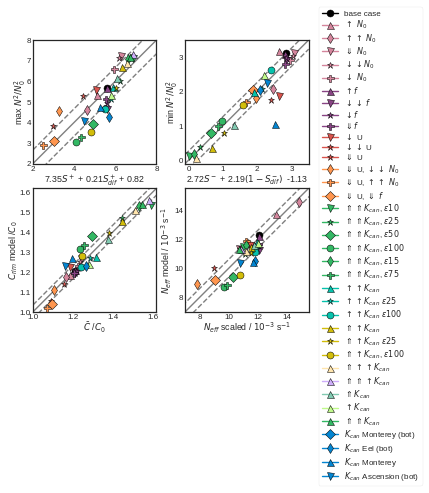

In [28]:
sns.set_context('paper')
plt.rcParams['font.size'] = 11.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2,wspace=0.2)
ax1 = plt.subplot(gs[0,0])
ax0 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[1,1])


# ---- plot 1:1 line ----
ax0.plot(np.linspace(-0.1,3.5,20),np.linspace(-0.1,3.5,20), '-',color='0.5')
ax1.plot(np.linspace(2,8,20),np.linspace(2,8,20), '-', color='0.5')
ax2.plot(np.linspace(5, 17, 20),np.linspace(5,17, 20),'-', color='0.5')
ax3.plot(np.linspace(1, 1.8, 20),np.linspace(1, 1.8, 20),'-', color='0.5')

# ---- plot error -----
# MSE ax0    
phi_array = np.array([(rec.Nbe_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nbe)**2/(rec.N**2)  for rec in records_epsilon])
x_fit = np.linspace(-0.1, 3.5, 50)
mean_sq_err = np.nanmean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([(rec.Nab_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])
x_fit = np.linspace(2,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax2    
phi_array = np.array([rec.N_eff_scaled/1E-3 for rec in records_epsilon])
sca_array = np.array([rec.Neff/1E-3 for rec in records_epsilon])
x_fit = np.linspace(5,17, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax3    
phi_array = np.squeeze(np.array([rec.Tr_scaled/rec.Tr0 for rec in records_epsilon]))
sca_array = np.squeeze(np.array([rec.Tr/rec.Tr0 for rec in records_epsilon]))
x_fit = np.linspace(1,1.8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
print('MSE for Cbar/Co is %f and RMSE is %f ' %(mean_sq_err, mean_sq_err**(1/2)))
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt0 = ax0.plot((rec.Nbe_scaled/rec.N)**2,(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    
    plt1 = ax1.plot((rec.Nab_scaled/rec.N)**2,(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2) 
    
    plt2 = ax2.plot(rec.N_eff_scaled/1E-3,rec.Neff/1E-3,
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    print(rec.name, rec.N_eff_scaled)
    plt3 = ax3.plot(rec.Tr_scaled/rec.Tr0,
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 7,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=0.5,
                     markeredgecolor = 'k',
                     label=rec.label2)

    
    
# ---- aesthetics -----
ax0.set_xlim(-0.1,3.5)
ax0.set_ylim(-0.1,3.5)

ax1.set_xlim(2,8)#
ax1.set_ylim(2,8)

ax2.set_xlim(7,15.5)
ax2.set_ylim(7,15.5)

ax3.set_xlim(1,1.62)
ax3.set_ylim(1,1.62)


ax0.set_ylabel('min $N^2/N^2_0$',labelpad=-1.5)
ax1.set_ylabel('max $N^2/N^2_0$',labelpad=-1.5)
ax0.set_xlabel(r'%1.2f$S^-$ + %1.2f$(1-S^-_{dif})$  %1.2f' %(reg_be.coef_[0], 
                                                         reg_be.coef_[1], 
                                                         reg_be.intercept_),labelpad=0.5)
ax1.set_xlabel(r'%1.2f$S^+$ + %1.2f$S^+_{dif}$ + %1.2f' %(reg_ab.coef_[0], 
                                                          reg_ab.coef_[1], 
                                                          reg_ab.intercept_),labelpad=0.5)

ax2.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$', labelpad=0)
ax2.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.0)
ax3.set_ylabel(r'$C_{rim}$ model /$C_0$', labelpad=0)
ax3.set_xlabel(r'$\bar{C}$ /$C_0$', labelpad=0.0)

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)
ax3.tick_params(axis='x', pad=2)
ax2.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)
ax3.tick_params(axis='y', pad=2)
ax2.tick_params(axis='y', pad=2)

ax0.legend(bbox_to_anchor=(1.05,1.3), ncol=1,columnspacing=0.1,labelspacing=0.1,frameon=True )

ax0.set_aspect(1)
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

#ax1.text(0.1,0.85,'Eqn. 22',transform=ax1.transAxes)
#ax0.text(0.1,0.85,'Eqn. 24',transform=ax0.transAxes)
#ax2.text(0.1,0.85,'Eqn. 27',transform=ax2.transAxes)
#ax3.text(0.1,0.85,'Eqn. 25',transform=ax3.transAxes)

#ax1.text(0.87,0.05,'(a)',transform=ax1.transAxes)
#ax0.text(0.87,0.05,'(b)',transform=ax0.transAxes)
#ax3.text(0.87,0.05,'(c)',transform=ax3.transAxes)
#ax2.text(0.87,0.05,'(d)',transform=ax2.transAxes)

plt.savefig('figure10_v2_talk.eps',format='eps',bbox_inches='tight')


MSE for Cbar/Co is 0.001174 and RMSE is 0.034271 


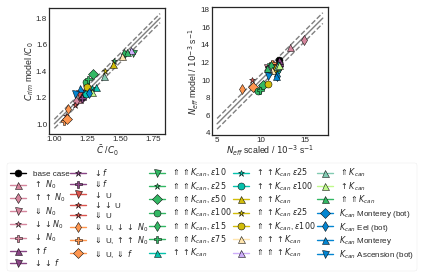

In [29]:
sns.set_context('paper')
plt.rcParams['font.size'] = 11.0
f = plt.figure(figsize = (5,7)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2,wspace=0.4)
ax2 = plt.subplot(gs[0])
ax3 = plt.subplot(gs[1])


# ---- plot 1:1 line ----
ax3.plot(np.linspace(5, 17, 20),np.linspace(5,17, 20),'-', color='0.5')
ax2.plot(np.linspace(1, 1.8, 20),np.linspace(1, 1.8, 20),'-', color='0.5')

# ---- plot error -----
# MSE ax2    
phi_array = np.array([rec.N_eff_scaled/1E-3 for rec in records_epsilon])
sca_array = np.array([rec.Neff/1E-3 for rec in records_epsilon])
x_fit = np.linspace(5,17, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax3    
phi_array = np.squeeze(np.array([rec.Tr_scaled/rec.Tr0 for rec in records_epsilon]))
sca_array = np.squeeze(np.array([rec.Tr/rec.Tr0 for rec in records_epsilon]))
x_fit = np.linspace(1,1.8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('MSE for Cbar/Co is %f and RMSE is %f ' %(mean_sq_err, mean_sq_err**(1/2)))

# ---- plot scaling ----
for rec in records_real:
      
    plt2 = ax3.plot(rec.N_eff_scaled/1E-3,rec.Neff/1E-3,
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    
    plt3 = ax2.plot(rec.Tr_scaled/rec.Tr0,
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 7,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=0.5,
                     markeredgecolor = 'k',
                     label=rec.label2)

    
    
# ---- aesthetics -----
#ax3.set_xlim(5,15.5)
#ax3.set_ylim(5,15.5)

#ax2.set_xlim(1,1.62)
#ax2.set_ylim(1,1.62)


ax3.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$', labelpad=0)
ax3.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.0)
ax2.set_ylabel(r'$C_{rim}$ model /$C_0$', labelpad=0)
ax2.set_xlabel(r'$\bar{C}$ /$C_0$', labelpad=0.0)

ax3.tick_params(axis='x', pad=2)
ax2.tick_params(axis='x', pad=2)

ax3.tick_params(axis='y', pad=2)
ax2.tick_params(axis='y', pad=2)

ax2.legend(bbox_to_anchor=(3.2,-0.2), ncol=5,columnspacing=0.1,labelspacing=0.1,frameon=True )

ax2.set_aspect(1)
ax3.set_aspect(1)

#ax3.text(0.1,0.85,'Eqn. 27',transform=ax3.transAxes)
#ax2.text(0.1,0.85,'Eqn. 25',transform=ax2.transAxes)

#ax3.text(0.87,0.05,'(b)',transform=ax3.transAxes)
#ax2.text(0.87,0.05,'(a)',transform=ax2.transAxes)

plt.savefig('scaling_w_Ls_talk.eps',format='eps',bbox_inches='tight')


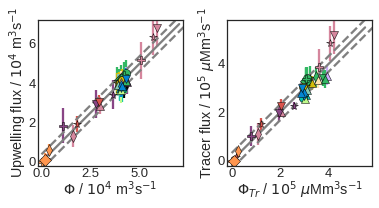

In [39]:
sns.set_context('talk')
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (6,3)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2, wspace=0.3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

# ---- plot 1:1 lines ----
ax0.plot(np.linspace(0,7,50),np.linspace(0,7,50),'-', color='0.5')
ax1.plot(np.linspace(0,5.5,50),np.linspace(0,5.5,50),'-', color='0.5')

# ---- plot errors ----
# MSE ax0    
phi_array = np.array([rec.Phi/1E4 for rec in records_dyn])
sca_array = np.array([rec.Phi_scaled/1E4  for rec in records_dyn])
x_fit = np.linspace(0,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([rec.PhiTr_scaled/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5 for rec in records_epsilon])
x_fit = np.linspace(0,6, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt1 = ax0.errorbar(rec.Phi_scaled/1E4,
                        rec.Phi/1E4,
                        yerr=rec.Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 8,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)
    
    plt1 = ax1.errorbar(rec.PhiTr_scaled/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 8,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)


# ---- aesthetics ----
ax0.set_ylabel('Phi',labelpad=0.8)
ax0.set_ylabel('Upwelling flux / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5)
ax1.set_ylabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlabel(r'$\Phi$ / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5 )
ax1.set_xlabel(r'$\Phi_{Tr}$ / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlim(-0.2,7.2)
ax0.set_ylim(-0.2,7.2)

ax1.set_xlim(-0.2,5.8)
ax1.set_ylim(-0.2,5.8)

#ax0.text(0.1,0.85,'Eqn. 28',transform=ax0.transAxes)
#ax1.text(0.1,0.85,'Eqn. 29',transform=ax1.transAxes)

#ax0.text(0.9,0.05,'(a)',transform=ax0.transAxes)
#ax1.text(0.9,0.05,'(b)',transform=ax1.transAxes)

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)


#ax0.plot(57261.9871812/1E4,40630.372436/1E4, 'o', color='brown')
#ax1.plot(520483.538981/1E5,298566.920079/1E5, 'o', color='brown')
plt.savefig('figure11_v2_talk.eps',format='eps',bbox_inches='tight')


base
higher $N$
highest $N$
lower $N$
higher $N$
medium $N$
higher $f$
lower $f$
low $f$
lowest $f$
lower $U$
low $U$
lowest $U$
lowest $U$, lowest $N$
lowest $U$, highest $N$
lowest $U$, lowest $f$
$\K_{can}=10^{-2}$, $\epsilon=10$
$\K_{can}$, $\epsilon=25$
$\K_{can}$, $\epsilon=50$
$\K_{can}$, $\epsilon=100$
$\K_{can}$, $\epsilon=15$
$\K_{can}$, $\epsilon=75$
$\K_{can}=5\times10^{-3}$, $\epsilon=5$
$\K_{can}=1\times10^{-3}$, $\epsilon=25$
$\K_{can}=1\times10^{-3}$, $\epsilon=100$
$\K_{can}=10^{-3}$, $\epsilon=5$
$\K_{can}=5\times10^{-3}$, $\epsilon=25$
$\K_{can}=5\times10^{-3}$, $\epsilon=100$
$K_{can}=8\times10^{-3}$, $\epsilon=5$
$K_{can}=1.2\times10^{-2}$, $\epsilon=5$
$K_{can}=2.5\times10^{-3}$, $\epsilon=5$
$K_{can}=5\times10^{-4}$, $\epsilon=5$
$K_{can}=10^{-2}$, $\epsilon=5$
$\K_{can}$ Mty, bottom
$\K_{can}$ Eel, bottom
$\K_{can}$ Mty, rim
$\K_{can}$ Asc, bottom


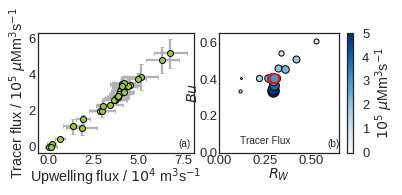

In [32]:
sns.set_context('talk')
sns.set_style("white")
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (6,2.2)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2, width_ratios=(1.0,1), wspace=0.1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# ---- plot scaling ----
for rec in records_real[:]:
    print(rec.label)
    plt1 = ax0.errorbar(rec.Phi/1E4,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        xerr = rec.Phi_std/1E4,
                        marker = '.',
                        markersize = 12,
                        color = 'yellowgreen',
                        markeredgewidth=1,
                        markeredgecolor = 'k',
                        label=rec.label2,
                        capsize=2,
                        ecolor = '0.7')
    if rec.kv <= 1E-5:
        plt1 = ax1.scatter(Ro(U=rec.u_mod, f=rec.f, R=rec.Wiso),
                           Bu(rec.N, rec.f,rec.W,Hs),
                           c = rec.PhiTr/1E5,
                           vmin=0, vmax=5,
                           cmap='Blues',
                           marker = 'o',
                           s = (rec.PhiTr/1E5)*25,
                           linewidths=1,
                           edgecolors='k',
                           )
    else:
        plt1 = ax1.scatter(Ro(U=rec.u_mod, f=rec.f, R=rec.Wiso),
                           Bu(rec.N, rec.f,rec.W,Hs),
                           c = rec.PhiTr/1E5,
                           vmin=0, vmax=5,
                           cmap='Blues',
                           marker = 'o',
                           s = (rec.PhiTr/1E5)*25,
                           linewidths=1,
                           edgecolors='r',
                           )
# Longer canyon runs  
cb=plt.colorbar(plt1 )
cb.set_label('$10^5$ $\mu$Mm$^3$s$^{-1}$')
# ---- aesthetics ----
ax0.set_xlabel('Upwelling flux / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5)
ax0.set_ylabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax1.set_xlabel('$R_W$', labelpad=-0.5)
ax1.set_ylabel('$Bu$', labelpad=-0.5)

ax1.set_xlim(0,0.65)
ax1.set_ylim(0.0,0.65)

ax0.tick_params(axis='x', pad=2)
ax0.tick_params(axis='y', pad=2)

ax1.tick_params(axis='x', pad=2)
ax1.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)

ax1.text(0.11,0.05,'Tracer Flux')

ax0.text(0.9,0.05,'(a)',transform=ax0.transAxes)
ax1.text(0.9,0.05,'(b)',transform=ax1.transAxes)
plt.savefig('figure_fluxes_comparison_talk.eps',format='eps',bbox_inches='tight')


#### MISC.

Conversion form $\mu Mm^3$ of $NO^-_3$ to kg of $NO^-_3$:

molecular weight of $NO^-_3$ = 3x16 O + 1x14 N = 62 g/mol

$\mu$Mm$^3$  = 1 x $10^{-6}$ x mol/0.001 m$^3$ x 1 m$^3$ =  $10^{-3}$ mol

$10^{-3}$ mol $NO_3$ = $10^{-3}$ mol x 62 g/mol = 0.062 g = $6.2 \times 10^{-5}$ kg